In [1]:
import numpy as np
from scipy.linalg import eigvals, eig
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from numba import njit

from scipy.sparse import eye, diags

In [2]:
%%time
N = 10000
H = diags(np.linspace(-1, 1, N))
a = 0.1

def G_operator(ham, Emax, Emin):
    Emax=Emax+0.05
    Emin=Emin-0.05
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax+0.05
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0]) * Ec)/E0


G = G_operator(H, 1, -1)
F = F_operator(H, 1, a)
a_r = a/1

CPU times: user 7.04 ms, sys: 4.93 ms, total: 12 ms
Wall time: 10.2 ms


In [3]:
def low_E_filter(ψ_rand, H, k):
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_rand
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H@ψ_nm1
            continue
            
        ψ_np1 = 2*H@ψ_n - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
    return ψ_n

def basis(ψ_proj, H, indices):
    ψ_basis = []
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_proj
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H@ψ_nm1
            continue
            
        ψ_np1 = 2*H@ψ_n - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
        if i in indices:
            ψ_basis.append(ψ_n)
    return ψ_basis

CPU times: user 45.5 ms, sys: 8.21 ms, total: 53.7 ms
Wall time: 62.6 ms


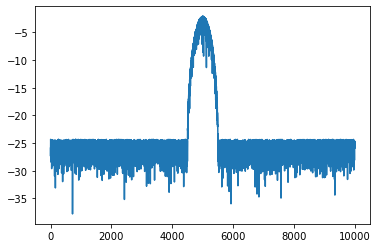

In [4]:
%%time
ψ_rand = np.random.rand(N)
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12/a))
ψ_proj = ψ_proj/np.linalg.norm(ψ_proj)

plt.plot(np.log(np.abs(ψ_proj)))

In [5]:
%%time
d = int(a*N*2)
n = int((d*1.5 - 1)/2)
Kd = int(n*np.pi/a_r)
indices = np.arange(np.pi/a_r, (n+1)*np.pi/a_r, np.pi/a_r).astype(int)

ψ_basis = basis(ψ_proj, G, indices) ## The bottleneck step

norm = np.linalg.norm(ψ_basis, axis=1)
ψ_basis = ψ_basis/norm[:, np.newaxis]


S = ψ_basis@ψ_basis.T
H_proj = ψ_basis@H@ψ_basis.T

CPU times: user 8.94 s, sys: 593 ms, total: 9.53 s
Wall time: 9.53 s


In [6]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 4.02 s, sys: 145 ms, total: 4.16 s
Wall time: 4.15 s


In [8]:
values = eigvals(H_proj_red)

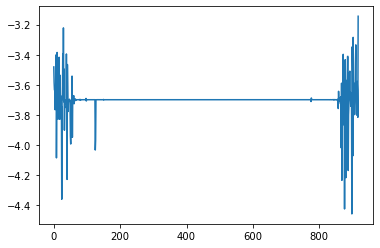

In [9]:
plt.plot(np.log10(np.diff(np.sort(np.real(values)))))

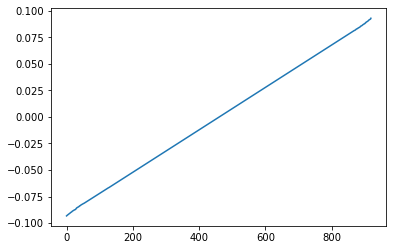

In [10]:
plt.plot(np.sort(np.real(values)))